# Pulse arrival times from the Crab pulsar

In [1]:
import os
import numpy as np
from __future__ import (division, absolute_import, print_function)
from scipy import interpolate

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.time import Time

from  matplotlib import pyplot as plt
import matplotlib

from math import pi

%matplotlib inline

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

## 1. Reading Data

The ToAs are recorded as a time value in [Modified Julian Date](http://tycho.usno.navy.mil/mjd.html) (MJD). The error is recorded in microseconds.

The barytable has six columns: Firstly the year, month, day number, followed by x, y, z components of the vector in [astronomical units](https://en.wikipedia.org/wiki/Astronomical_unit). This table should be for the year your observations are recorded.

In [11]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP")

barytable_dir = os.path.join(data_dir, "BaryTables")
toa_dir = os.path.join(data_dir, "TOAs")
period_dir = os.path.join(data_dir, "PeriodEstimates")

# Functions for reading data
# --------------------------
def load_barytable(file_name):
    """
    Load the barytable file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: arrays with year, month, day, xpos, ypos, zpos
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(barytable_dir, file_name)
    barytable = np.loadtxt(data_file, unpack=True)
    
    return barytable

def load_toas(file_name):
    """
    Load the time of arrivals from file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: array containing time of arrival
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(toa_dir, file_name)
    toas = np.loadtxt(data_file, usecols=(2,3))
    
    return toas
    
def read_pest(file_name):
    """
    Read the period estimate form file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: float with the period estimate
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(period_dir, file_name)
    with open(data_file) as dfile:
        line = dfile.read()
        
    period = float(line[23:-8])
    
    return period

### 1.1 Load All Data

In [10]:
# Crab 1 data
crab1_barytable = load_barytable('Crab1Barytable')
crab1_toas = load_toas('Crab1ToAs')
crab1_pest = read_pest('Crab1TEst')

# Crab 2 data...

0.0337552412


## 2. Interpolation of Barycenter


In [4]:
def compose_date(years, months=1, days=1,
                 hours=None, minutes=None, seconds=None,
                 milliseconds=None):
    """
    Converts array of years, months etc. into numpy64 date array.
    
    @param years :: array of years corresponding to each date
    @param months :: array of months corresponding to each date
    @param days :: array of days corresponding to each date
    @param hours :: array of hours corresponding to each date
    @param minutes :: array of minutes corresponding to each date
    @param seconds :: array of seconds corresponding to each date
    
    @returns :: array of numpy64date format dates
    """
    
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]')
    vals = (years, months, days, hours, minutes, seconds, milliseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def mjd_convert(raw_data):
    """
    Converts normal dates from psrchive to modified julian dates.
    
    @param raw_data :: raw array of year, month, day as read from
                       the data file on the barycentre
                       
    @returns :: modified julian date format times
    """
    
    dates = raw_data[:3]
    midnights = np.zeros((4,len(dates[0])))
    times_raw = np.concatenate((dates,midnights))
    times = compose_date(times_raw[0], times_raw[1], times_raw[2],
                         times_raw[3], times_raw[4], times_raw[5],
                         times_raw[6])
    converted_times =  Time(times.astype('string').tolist(), 
                            format='isot', scale='utc')
    mjd_times = converted_times.mjd
    
    return mjd_times

def bary_distance(raw_data):
    """
    Computes the distance from the barycenter to Earth
    on a particular day at a particular time.
    
    @param raw_data :: raw array of year, month, day as read from
                       the data file on the barycentre
                       
    @returns :: magnitude of the x,y,z vector from the raw data
    """
    
    xyz = np.transpose(raw_data[3:])
    dist = np.zeros(len(xyz))
    for i, vect in enumerate(xyz):
        dist[i] += np.sqrt(vect[0]**2 + vect[1]**2 + vect[2]**2)
    
    return dist

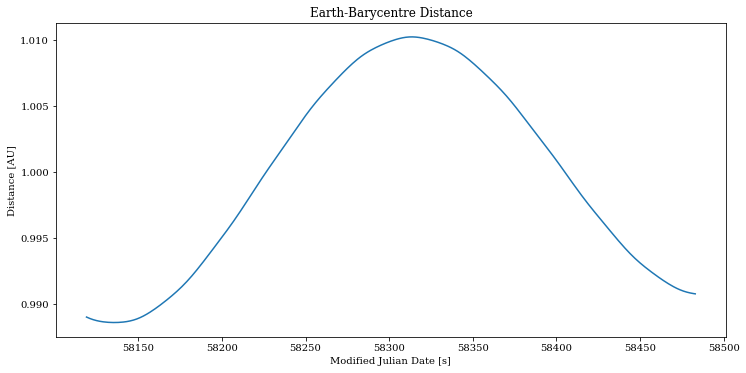

In [5]:
# Plot barycenter data
mjd_times = mjd_convert(crab1_barytable)
distances = bary_distance(crab1_barytable)
bary_coord = np.transpose(crab1_barytable[3:])
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(mjd_times, distances)
plt.xlabel("Modified Julian Date [s]")
plt.ylabel("Distance [AU]")
plt.title("Earth-Barycentre Distance")
plt.subplots_adjust(bottom=0.1, top=0.9)

In [6]:
def lag_int(time, order):
    """
    Performs a lagrangian interpolate of order n
    to more accurately determine the Earth-Bary distance at
    a specific time.
    
    @param time :: desired time for which the distance should
                   be calculated
    @param order:: order of the lagrangian interpolate to be calculated
    
    @returns :: the interpolated coordinates and their associated errors
    """
    
    if order == 1:
        raise RuntimeError("Order cannot be 1! Interpolate 1 point? What?")
        
    idxs = np.where(np.logical_and(mjd_times <= time + order/2,
                                   mjd_times >= time - order/2))
    xvals = mjd_times[idxs]
    yvals = distances[idxs]
    interp = interpolate.lagrange(xvals, yvals)
    coords, coords_errors = coord_interp(time, idxs, xvals)
    
    return coords, coords_errors

def coord_interp(time, idxs, xvals):
    """
    Performs a lagrangian interpolate of order n
    to more accurately determine the Earth-Bary coordinate
    at a specific time.
    
    @param time :: desired time for which the distance should
                   be calculated
    @param order :: order of the lagrangian interpolate to be calculated
    
    @returns :: the distance at the specified time and the error on it
    """
    
    coords = []
    coords_errors = []
    for i in range(0, 3):
        yvals = []
        for j in range(idxs[0][0], idxs[0][-1] + 1):
            yvals.append(bary_coord[j][i])
        
        interp = interpolate.lagrange(xvals, yvals)
        coords.append(interp(time))
        coords_errors.append(residual(yvals))
    
    return coords, coords_errors

def residual(yvals):
    """
    Function that finds the delta in determining
    the residuals of the lagrange interpolation formula.
    
    @param yvals :: the Bary-Earth distances of the interpolated
                    points in the data
    
    @returns :: the error due to interpolation on the yvals data
    """
    
    order = len(yvals)
    coeff = [0.125, 0.065, 0.042, 0.031, 
             0.024, 0.019, 0.016]
    delta = yvals
    
    for i in range(0, order-1):        
        delta = np.diff(delta)

    error = coeff[order-2] * delta
    
    return error[0]

## 3. Compute Delays

In [105]:
# Initialise some constants used throughout
# All these constants are in SI except where specified otherwise
pulsarpos = coord.SkyCoord(ra="05:34:31.93830",
                           dec="22:00:52.1758", 
                           unit=(u.hourangle,u.deg))

lovellpos = coord.EarthLocation.from_geodetic(53.2369, -2.3075)
earth_radius = 6378100
light_speed = 299792458

### 3.1 Compute the Earth delay

In [7]:
def earth_delay(times):
    """
    Computes the earth delay in seconds for a set of ToAs.
    
    @param times :: array of ToAs
    
    @returns :: the Earth delay in seconds
    """
    times = astrotime.Time(times, format='mjd')
    altaz = pulsarpos.transform_to(coord.AltAz(obstime=times,
                                               location=lovellpos))
    # Get radians altitude
    alt = coord.Angle(altaz.alt, u.radian)
    earth_delay = earth_radius * np.sin(alt)/light_speed
    
    return earth_delay

### 3.2 Compute Barycentre Delay

In [107]:
def bary_delay(times):
    """
    Calculates the delay from the center of the Earth to the
    barycenter.
    
    @param time :: time of pulse arrival
    
    @returns :: the delay from center of Earth to Barycenter
    """
    
    pulsarpos = coord.SkyCoord(ra="05:34:31.93830",
                               dec="22:00:52.1758", 
                               unit=(u.hourangle,u.deg))
    pulsarpos.representation = 'cartesian'
    psr_unit = np.array([pulsarpos.x, pulsarpos.y, pulsarpos.z])
    
    delay = []
    for i,time in enumerate(times):
        coords, coords_error = lag_int(time, 3)
        # AU per sec light speed
        light_speed = 0.00200399 
        delay.append(np.dot(coords, psr_unit)/light_speed)

    return delay

### 3.3 Barycenter Time

In [110]:
crab1_edelay = earth_delay(crab1_toas[:,0])
crab1_bdelay = bary_delay(crab1_toas[:,0])

barycenter_time = crab1_toas[:,0] + crab1_bdelay + crab1_edelay

## Residuals from a fixed period model



In [12]:
period_guess = crab1_pest;

def noRotation(period, t):
    """
    Function calculates the number of rotations of the star
    
    @param t :: time of arrivals w.r.t barycenter
    @param period_guess :: initial guess for the period of Crab pulsar
    
    @return n :: number of rotations of the pulsar
    @return
    """
    n = (t-2451545.0)/period
           
    return n

def residual(period, t):
    return  (t-2451545.0)%period

scipy.optimize.minimize(residual, period_guess, t, method="Nelder-Mead")

# residual = 

# Do fitting (try the polyfit routine in numpy)